In [179]:
import xarray as xr
#matched_dataX=xr.DataArray(np.array(matched_dataL),dims=['prof','info'])
infoString=["lon_ncar","lat_ncar","time_ncar","alt_ncar","IWC","lon_Ku","lat_Ku","time_Ku","iprof","irec","IWC_bf"]
#matched_dataX=matched_dataX.assign_coords(info=infoString)
#ds=xr.Dataset({'coincidence_data':matched_dataX})
#ds.to_netcdf('coincidence_data_15Jan2023.nc')
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

with nc.Dataset("coincidence_vertical_data_15Jan2023_2.nc") as f:
    coincidence_data=f.variables['coincidence_data'][:]

iprof=coincidence_data[:,-3].astype(int)
time_ncar=coincidence_data[:,2]
print(coincidence_data[:,-1].mean())

0.6255888641352968


In [73]:
print(iprof)
alt=coincidence_data[:,3]
print(alt)

[11793 11795 11800 ... 30524 30526 30527]
[6296. 6296. 6299. ... 3510. 3510. 3511.]


In [74]:
with nc.Dataset('/Users/mgrecu/AirborneData/IMPACTS2023_HIWRAP_KU_L1B_Rev-_20230115.h5') as f:
    print(f)
    time_Ku=f["Time/Data/TimeUTC"][iprof]
   
    dbz_ku=f["Products/Combined/Data/dBZe"][iprof,:]
    ldr=f["Products/Combined/Data/LDR"][iprof,:]
    lon=f["Navigation/Data/Longitude"][iprof]
    lat=f["Navigation/Data/Latitude"][iprof]
    height=f["Navigation/Data/Height"][iprof]
    roll=f["Navigation/Data/Roll"][iprof]
    vdop=f["Products/Combined/Data/Velocity_corrected"][iprof,:]
    radar_range=f["Products/Information/Range"][:]

with nc.Dataset('/Users/mgrecu/AirborneData/IMPACTS2023_HIWRAP_KA_L1B_Rev-_20230115.h5') as f:
    
    lon_ka=f["Navigation/Data/Longitude"][:]
    lat_ka=f["Navigation/Data/Latitude"][:]

lat_Ku=coincidence_data[:,6]
lon_Ku=coincidence_data[:,5]
iprof_ka=[]
for i in range(len(iprof)):
    d=np.sqrt((lat_Ku[i]-lat_ka)**2+(lon_Ku[i]-lon_ka)**2)
    ind=np.argmin(d)
    iprof_ka.append(ind)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: Information, Navigation, Products, Time


In [75]:
iprof_ka=np.array(iprof_ka)
with nc.Dataset('/Users/mgrecu/AirborneData/IMPACTS2023_HIWRAP_KA_L1B_Rev-_20230115.h5') as f:
    
    lon_Ka=f["Navigation/Data/Longitude"][iprof_ka]
    lat_Ka=f["Navigation/Data/Latitude"][iprof_ka]
    time_Ka=f["Time/Data/TimeUTC"][iprof_ka]
    dbz_ka=f["Products/Combined/Data/dBZe"][iprof_ka,:]

0.6255888641352968


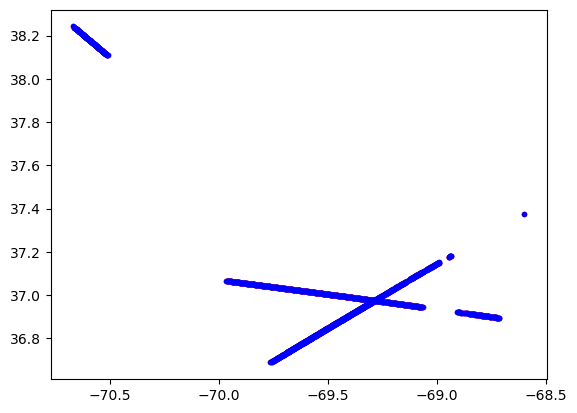

In [235]:
plt.plot(lon_Ku,lat_Ku,'r.')
plt.plot(lon_Ka,lat_Ka,'b.')
IWC=coincidence_data[:,-1]
zmeasL=[]
yL=[]
timeL=[]
altL=[]
tempL=[]
dbzprofs=[]
for i in range(len(iprof)):
    h1=(height[i]-radar_range)*np.cos(np.radians(roll[i]))
    dh=np.abs(h1-alt[i])
    ind1=np.argmin(dh)
    #print(h1[ind1],alt[i])
    
    if dbz_ku[i,ind1]==dbz_ku[i,ind1] and dbz_ka[i,ind1]==dbz_ka[i,ind1]:
        zmeasL.append([dbz_ku[i,ind1],dbz_ka[i,ind1]+1.0])
        yL.append(IWC[i])
        timeL.append(time_ncar[i])
        tempL.append((2300-alt[i])/1e3*6.5)
        altL.append(alt[i])
        dbzprofs.append(np.array([dbz_ku[i,:ind1+1],dbz_ka[i,:ind1+1]]).T)

print(IWC.mean())

In [118]:
print(np.radians(30),np.pi/6)


0.5235987755982988 0.5235987755982988


In [251]:
#plt.scatter(np.array(zmeasL)[:,0],np.array(zmeasL)[:,1],c=IWC)
fh=nc.Dataset("simulatedZ_impacts2020_bf_Kuo.nc");
vars="Nw,dm,iwc,iwc_ncar,tempC,zKu,attKu,kextKu,kscatKu,gKu,Ka,attKa,kextKa,kscatKa,gKa,zW,attW,kextW,kscatW,gW"
psd_Data=fh.variables['psd_Data'][:]
Nw=psd_Data[:,0]
dm=psd_Data[:,1]
iwc=psd_Data[:,2]
tempC=psd_Data[:,4]
zKuDB=psd_Data[:,5]
attKuDB=psd_Data[:,6]
zKaDB=psd_Data[:,10]
attKaDB=psd_Data[:,11]
x=[zKuDB+np.random.randn(zKuDB.shape[0])*0.5,zKaDB+np.random.randn(zKaDB.shape[0])*1.5]
y=[np.log10(1+iwc/1e-2),dm,attKuDB,attKaDB]
y=[iwc,dm,attKuDB,attKaDB]
x=np.array(x).T
y=np.array(y).T
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=45,weights='distance')
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=45, weights='distance')

In [257]:
from chaseRet import *
nw_nn,dm_nn,iwc_nn=retr(np.array(zmeasL),np.array(tempL))
dr=26.5
piaKuL=[]
piaKaL=[]
for dbz1 in dbzprofs:
    #print(dbz1.shape)
    a=np.nonzero(dbz1[:,0]>-10)
    b=np.nonzero(dbz1[a[0],1]>-10)
    if len(b[0])<1:
        piaKuL.append(0)
        piaKaL.append(0)
        continue
    y1=knn.predict(dbz1[a[0][b],:])
    attKu1=y1[:,2]
    attKa1=y1[:,3]
    piaKu1=2*attKu1.sum()*dr
    piaKa1=2*attKa1.sum()*dr
    piaKuL.append(min(2,piaKu1))
    piaKaL.append(min(9,piaKa1))
    #break

In [254]:
print(y1.shape)
print(radar_range[2]-radar_range[1])
print(len(zmeasL),len(piaKuL),len(piaKaL))
zmeas_corrected_L=np.array(zmeasL)
zmeas_corrected_L[:,0]=zmeas_corrected_L[:,0]+np.array(piaKuL)
zmeas_corrected_L[:,1]=zmeas_corrected_L[:,1]+np.array(piaKaL)


(178, 4)
26.25
1283 1283 1283


[[1.         0.71021759]
 [0.71021759 1.        ]]
0.2560416 0.7645168337449985
[[1.         0.95373746]
 [0.95373746 1.        ]]
0.2968923401069533 0.48695582477045635 0.2560416 0.7645168337449985


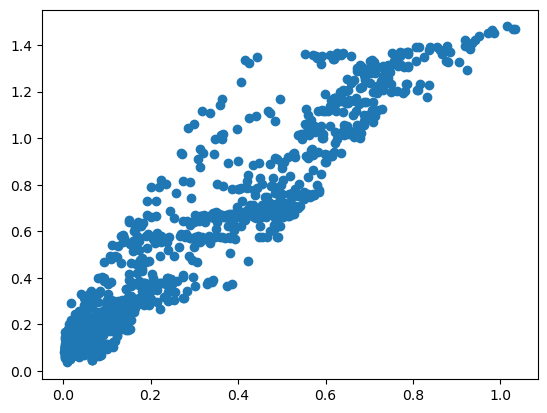

In [260]:
yout=knn.predict(np.array(zmeas_corrected_L))
yout_no_pia=knn.predict(np.array(zmeasL))
iwc_pred=yout[:,0]
iwc_no_pia=yout_no_pia[:,0]
print(np.corrcoef(iwc_pred,yL))
print(np.mean(iwc_nn),np.mean(yL))
print(np.corrcoef(iwc_nn,iwc_pred))
plt.scatter(iwc_nn,iwc_pred)
print(np.mean(iwc_no_pia),np.mean(iwc_pred),np.mean(iwc_nn),np.mean(yL))

[[1.         0.71021759]
 [0.71021759 1.        ]]
0.48695582477045635 0.7645168337449985


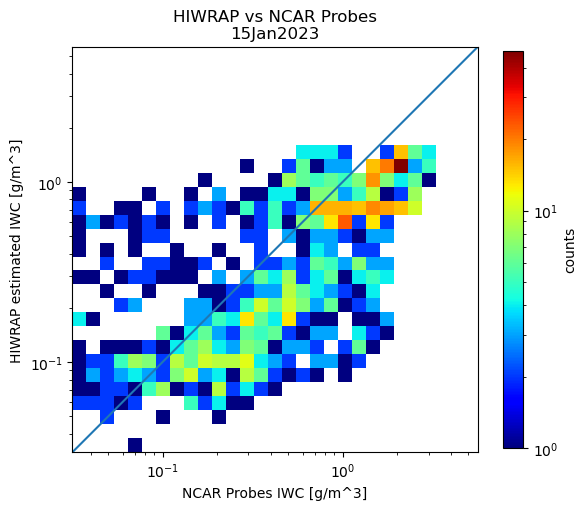

In [259]:

iwc_pred=(10**yout[:,0]-1)*1e-2
iwc_pred=yout[:,0]
print(np.corrcoef(iwc_pred,yL))
#plt.scatter(yout[:,0],yL)
import matplotlib.colors as colors
bins=np.logspace(-1.5,0.75,30)
plt.figure(figsize=(6,6))
ax=plt.subplot(111)
h2=ax.hist2d(yL,1.0*iwc_pred,bins=bins,norm=colors.LogNorm(),cmap='jet')
plt.xscale('log')
plt.yscale('log')
ax.set_aspect('equal')
plt.plot([0.01,10],[0.01,10])
plt.title('HIWRAP vs NCAR Probes\n15Jan2023')
print(np.mean(iwc_pred),np.mean(yL))
plt.xlabel('NCAR Probes IWC [g/m^3]')
plt.ylabel('HIWRAP estimated IWC [g/m^3]')
plt.colorbar(h2[3],label='counts',shrink=0.7)
plt.tight_layout()
plt.savefig('IWC_HIWRAP_vs_NCAR.png')

#ax.set_aspect('equal')


In [244]:
print(np.max(piaKuL),np.max(piaKaL))

3.872540982033181 96.41681267652054


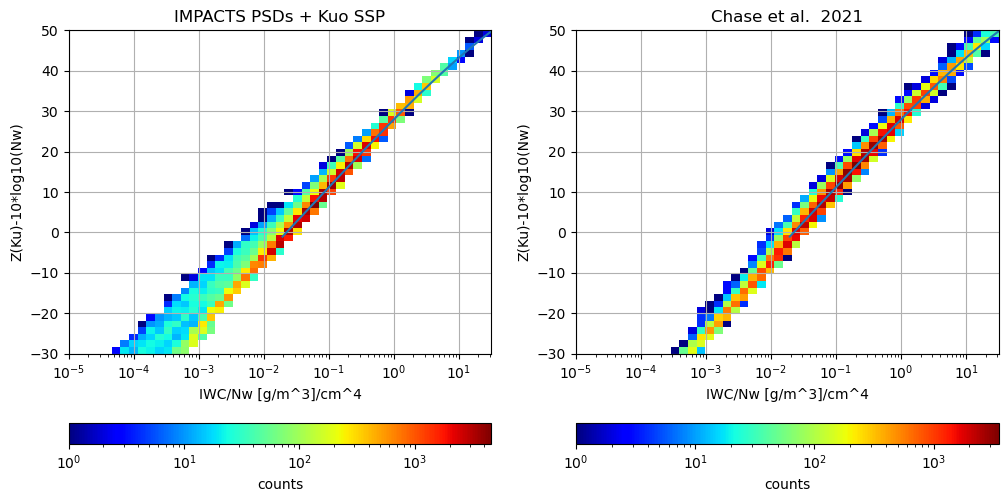

In [217]:
xbin=np.logspace(-5,1.5,50)
ybin=np.linspace(-30,50,50)
plt.figure(figsize=(12,6))
plt.subplot(121)
h3=plt.hist2d((iwc/Nw),zKuDB-10*np.log10(Nw),bins=(xbin,ybin),norm=colors.LogNorm(),cmap='jet')
plt.xscale('log')
plt.grid()
plt.colorbar(h3[3],label='counts',orientation='horizontal',shrink=1)
import lkTables as lkt
scatTables=lkt.scattTables()
plt.plot(scatTables.swc/0.08,scatTables.zKuS-10*np.log10(0.08),label='GPM Lookup table')
plt.xlabel('IWC/Nw [g/m^3]/cm^4')
plt.ylabel('Z(Ku)-10*log10(Nw)')
plt.title("IMPACTS PSDs + Kuo SSP")
plt.subplot(122)
with nc.Dataset('Chase_et_al_2021_NN/Unrimed_simulation_wholespecturm_train_V2.nc') as f:
    zKu_chase=f.variables['Z'][:]
    Nw_chase=f.variables['Nw'][:]*1e-8
    IWC_chase=f.variables['IWC'][:]


h4=plt.hist2d((IWC_chase/Nw_chase),zKu_chase-10*np.log10(Nw_chase),bins=(xbin,ybin),norm=colors.LogNorm(),cmap='jet')
plt.xscale('log')
plt.plot(scatTables.swc/0.08,scatTables.zKuS-10*np.log10(0.08),label='GPM Lookup table')
plt.grid()
plt.xlabel('IWC/Nw [g/m^3]/cm^4')
plt.ylabel('Z(Ku)-10*log10(Nw)')
plt.title("Chase et al.  2021")
plt.colorbar(h4[3],label='counts',orientation='horizontal',shrink=1)
plt.savefig('scatteringTables.png')


In [195]:
print(Nw[0:10])

[28.8238622  32.59475611 45.19956507 38.51093651 48.99651139 52.23415584
 25.19679684 51.92618966 41.01824394 23.86046774]


0.00025929202092811465
[16.94916667 16.95       16.95111111 16.95138889 16.95166667 16.95194444
 16.9525     16.95277778 16.95361111 16.95388889 16.95444444 16.95472222
 16.955      16.95527778 16.95555556 16.95583333 16.95611111 16.95638889
 16.95666667 16.95694444 16.95722222 16.9575     16.95777778 16.95916667
 16.95944444 16.95972222]
[5364. 5364. 5366. 5366. 5367. 5367. 5369. 5370. 5371. 5371. 5371. 5372.
 5372. 5373. 5374. 5375. 5375. 5376. 5376. 5376. 5377. 5377. 5377. 5378.
 5378. 5378.]
57.0


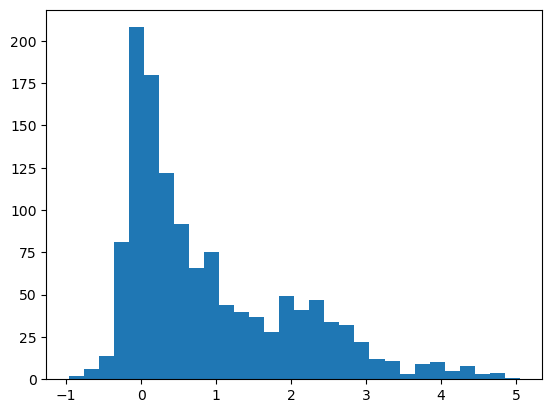

In [104]:
h1=plt.hist(np.array(yL)-np.array(iwc_pred),bins=30)
print(min(yL))
a=np.nonzero(np.array(yL)>5)
print(np.array(timeL)[a]/3600)
print(np.array(altL)[a])
print(95*60/100.)


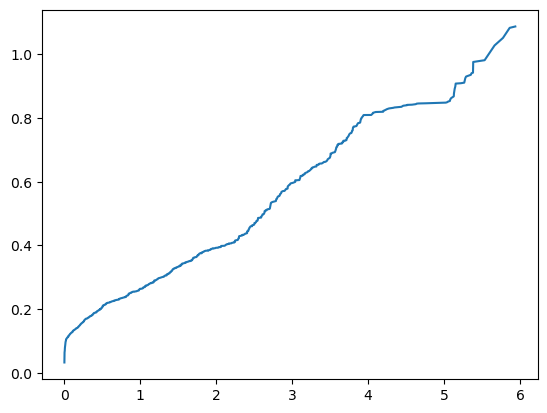

In [86]:
plt.plot(np.sort(yL),np.sort(iwc_pred))

[[1.         0.67141224]
 [0.67141224 1.        ]]


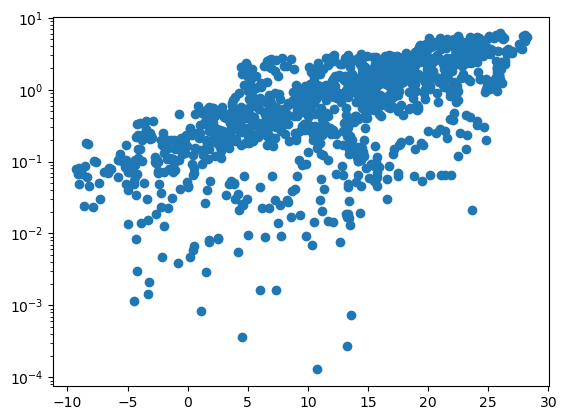

In [44]:
zmeasL=np.array(zmeasL)
plt.scatter(zmeasL[:,0],yL)
plt.yscale('log')
print(np.corrcoef(zmeasL[:,1],np.log10(yL)))